In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from livelossplot import PlotLossesKeras
# import keras models
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.utils import to_categorical
import os
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.utils import plot_model

In [2]:
# set random seed globally
my_seed = 21
from numpy.random import seed
seed(my_seed)
import tensorflow as tf
tf.random.set_seed(my_seed) 
# tensorflow version
print(tf.__version__)

2.16.1


MAGIC Gamma Telescope Data Set

In [3]:
# Import dataframe from https://archive.ics.uci.edu/ml/datasets/magic+gamma+telescope

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data',
                 names = ['fLength','fWidth','fSize','fConc','fConc1','fAsym','fM3Long','fM3Trans','fAlpha','fDist','class'])
df

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g
...,...,...,...,...,...,...,...,...,...,...,...
19015,21.3846,10.9170,2.6161,0.5857,0.3934,15.2618,11.5245,2.8766,2.4229,106.8258,h
19016,28.9452,6.7020,2.2672,0.5351,0.2784,37.0816,13.1853,-2.9632,86.7975,247.4560,h
19017,75.4455,47.5305,3.4483,0.1417,0.0549,-9.3561,41.0562,-9.4662,30.2987,256.5166,h
19018,120.5135,76.9018,3.9939,0.0944,0.0683,5.8043,-93.5224,-63.8389,84.6874,408.3166,h


In [4]:
def buildDataSet (df, test_data_fraction):
    # encoding the target column
    le = LabelEncoder()
    label = le.fit_transform(df['class'])
    label

    encoded_df = df.copy()
    encoded_df.drop("class", axis=1, inplace=True)
    encoded_df["class"] = label

    # Set the total number of classes
    nb_classes = len(encoded_df['class'].unique())

    # Creating target and features
    X = encoded_df.drop(['class'], axis=1)
    y = encoded_df['class']

    # scale the variables
    sc = StandardScaler() 
    X_scaled = sc.fit_transform(X)

    # Split into train and test set and normalize data
    X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size = test_data_fraction,stratify=y) #, random_state = 0)


    return encoded_df, nb_classes, X_train, X_test, y_train, y_test

In [5]:
# build dataset on our dataframe
encoded_dataframe, nb_classes, X_train, X_test, y_train, y_test = buildDataSet (df, 0.2)

print(encoded_dataframe.head())

print("")

print(f"classes_in_dataset = {nb_classes}")

print("")

print(f"X_train.shape = {X_train.shape}")
print(f"X_test.shape = {y_train.shape}")
print(f"y_train.shape = {y_train.shape}")
print(f"y_test.shape = {y_test.shape}")

    fLength    fWidth   fSize   fConc  fConc1     fAsym  fM3Long  fM3Trans  \
0   28.7967   16.0021  2.6449  0.3918  0.1982   27.7004  22.0110   -8.2027   
1   31.6036   11.7235  2.5185  0.5303  0.3773   26.2722  23.8238   -9.9574   
2  162.0520  136.0310  4.0612  0.0374  0.0187  116.7410 -64.8580  -45.2160   
3   23.8172    9.5728  2.3385  0.6147  0.3922   27.2107  -6.4633   -7.1513   
4   75.1362   30.9205  3.1611  0.3168  0.1832   -5.5277  28.5525   21.8393   

    fAlpha     fDist  class  
0  40.0920   81.8828      0  
1   6.3609  205.2610      0  
2  76.9600  256.7880      0  
3  10.4490  116.7370      0  
4   4.6480  356.4620      0  

classes_in_dataset = 2

X_train.shape = (15216, 10)
X_test.shape = (15216,)
y_train.shape = (15216,)
y_test.shape = (3804,)


In [6]:
class CustomWeight(tf.keras.initializers.Initializer):
    def __init__(self):
        print('gg')
    def constant_weight(self,num):
        return tf.keras.initializers.Constant(num)
    
    def normal_weight(self,mean,stddev):
        return tf.keras.initializers.RandomNormal(mean, stddev)

In [14]:
def buildSequentialModel(hidden_layers_activation, first_layer_node_count, dropout_fraction, nb_classes, weight_class, wt_mean, wt_std, bias_mean, bias_std):
    # Build a Sequential Model.
    model = Sequential()

    model.add(Dense(first_layer_node_count, kernel_initializer=weight_class.normal_weight(wt_mean, wt_std), 
                    activation=hidden_layers_activation, 
                    bias_initializer=weight_class.normal_weight(bias_mean, bias_std)))
    model.add(Dropout(dropout_fraction))

    model.add(Dense(int(first_layer_node_count * 0.8), kernel_initializer=weight_class.normal_weight(wt_mean, wt_std), 
                    activation=hidden_layers_activation, 
                    bias_initializer=weight_class.normal_weight(bias_mean, bias_std)))
    model.add(Dropout(dropout_fraction))

    model.add(Dense(int(first_layer_node_count * 0.6), kernel_initializer=weight_class.normal_weight(wt_mean, wt_std), 
                    activation=hidden_layers_activation, 
                    bias_initializer=weight_class.normal_weight(bias_mean, bias_std)))
    model.add(Dropout(dropout_fraction))

    # Output Layer
    model.add(Dense(nb_classes, activation='softmax',  # Use 'softmax' for multi-class classification
                    kernel_initializer=weight_class.normal_weight(wt_mean, wt_std), 
                    bias_initializer=weight_class.normal_weight(bias_mean, bias_std)))

    return model


In [15]:
# defining mish activation function using tensors

def mish(x):
    return x * tf.math.tanh(tf.math.softplus(x))

get_custom_objects().update({'mish': Activation(mish)}) # saving custom function in keras custom objects to be called during model run

In [16]:
# Define activation functions
hidden_layer_activation_functions = ['mish', 'relu', 'gelu', 'selu', 'sigmoid', 'tanh', 'softmax']

# Define model parameters
First_Hidden_Layer_Tensor_Count = int(100)  # Ensure it's an integer
TrainTest_Split = 0.25
dropout_fraction = 0.3  # Dropout can remain as float
wt_mean = 0
wt_std = 0.5
bias_mean = 0
bias_std = 0.25


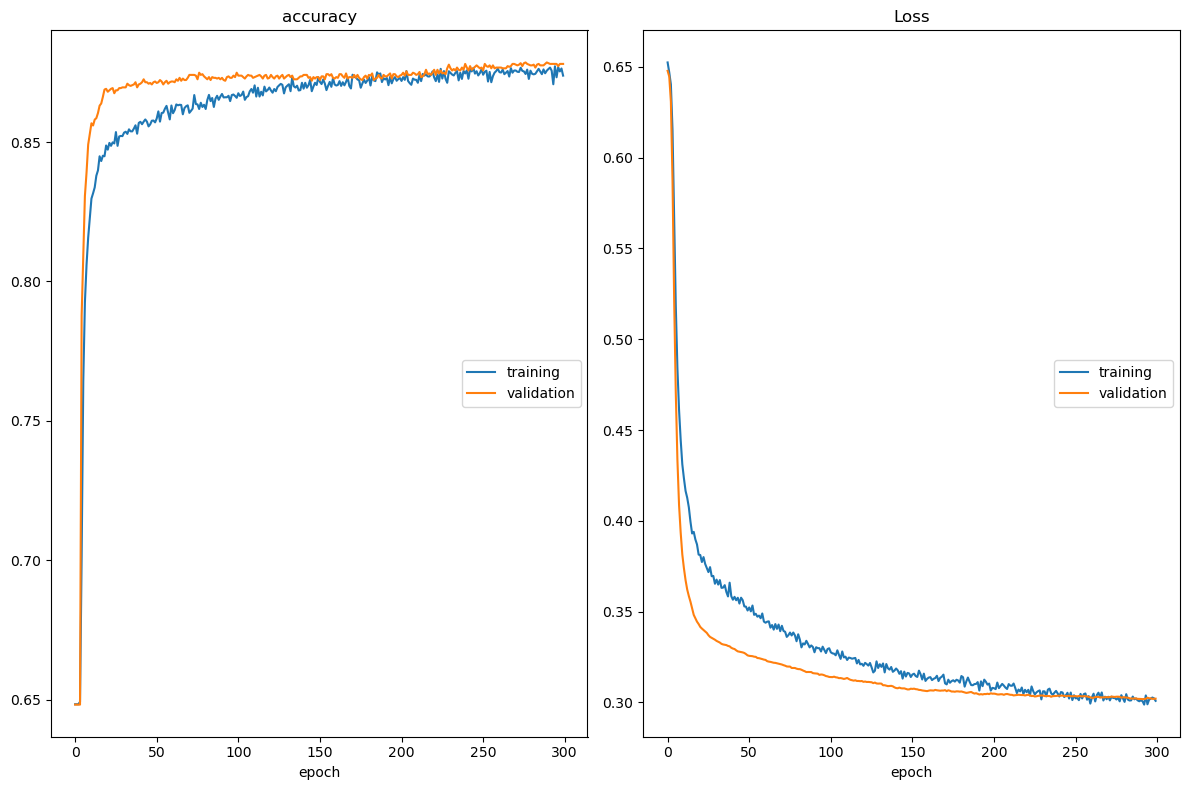

accuracy
	training         	 (min:    0.648, max:    0.877, cur:    0.874)
	validation       	 (min:    0.648, max:    0.879, cur:    0.878)
Loss
	training         	 (min:    0.299, max:    0.652, cur:    0.301)
	validation       	 (min:    0.302, max:    0.648, cur:    0.302)
Saving plot to: C:\Users\shubh\Deep Learning\2.Visualization\magicgamma_convergence_softmax.png


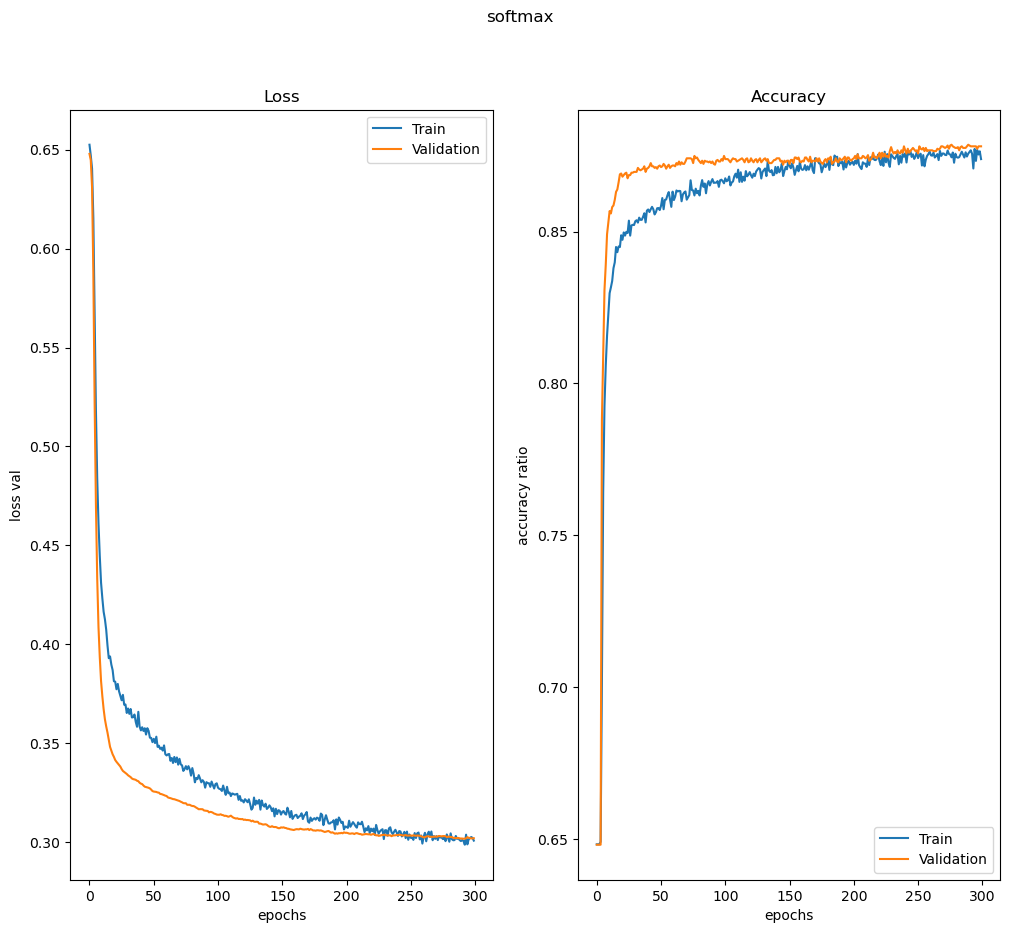

In [18]:
import os
import matplotlib.pyplot as plt
from tensorflow import keras
from livelossplot import PlotLossesKeras

for hidden_layer_activation in hidden_layer_activation_functions:
    # Instantiate model
    model = buildSequentialModel(
        hidden_layer_activation,
        int(First_Hidden_Layer_Tensor_Count),  # Ensure integer
        dropout_fraction,
        nb_classes,
        CustomWeight(),
        wt_mean,
        wt_std,
        bias_mean,
        bias_std
    )

    # Build model (if necessary)
    model.build(input_shape=(None, X_train.shape[1]))  # Ensure the model is built before accessing shapes

    # Debug: Print model layers and their output shapes
    print(f"\nModel architecture for activation: {hidden_layer_activation}")
    for layer in model.layers:
        print(f"Layer: {layer.name}, Output Shape: {layer.output.shape}")  # Use layer.output instead of layer.output_shape

    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )

    # Train model
    hist = model.fit(
        X_train, y_train,
        callbacks=[PlotLossesKeras()],
        batch_size=100,
        epochs=300,
        verbose=0,
        validation_data=(X_test, y_test)
    )

    # Plot training history
    fig, axs = plt.subplots(1, 2, figsize=(12, 10))
    fig.suptitle(hidden_layer_activation)

    axs[0].plot(hist.history['loss'])
    axs[0].plot(hist.history['val_loss'])
    axs[0].set_title('Loss')
    axs[0].legend(['Train', 'Validation'])
    axs[0].set(xlabel='epochs', ylabel='loss val')

    axs[1].plot(hist.history['accuracy'])
    axs[1].plot(hist.history['val_accuracy'])
    axs[1].set_title('Accuracy')
    axs[1].legend(['Train', 'Validation'])
    axs[1].set(xlabel='epochs', ylabel='accuracy ratio')

    # Save plot
    rem = len('\1.Modeling')
    absolute_path = os.path.abspath('')[:-(rem+1)]

    path = '2.Visualization'
    my_path = os.path.join(absolute_path, path, f"magicgamma_convergence_{hidden_layer_activation}.png")
    print(f"Saving plot to: {my_path}")  

    plt.savefig(my_path)
